In [1]:
# import TensorFlow as TF
import pandas as pd
import math
import matplotlib.pylab as plt
import numpy as np
import statistics
from statistics import mean, median


from sklearn import datasets
from sklearn.impute import SimpleImputer # used for handling missing data


In [2]:

df = pd.read_csv('data.csv')
data_top = df.head()
copy = df.copy() 

# 1 - Remove rows where the target column (Scope1) is NaN.

#copy = copy[copy['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].notna()] # drop all rows with NaN in target column
#copy = copy.reset_index() 

# 2 - Replace all NaN from the attribute columns and replace for mean of that column

# copy = copy.fillna(copy.mean())
# col_names = copy.columns
# sub2[col_names].fillna((sub2[col_names].mean()), inplace=True)

# create dictionary with 
def create_dict(target_var, df): 
    org_ids = list(df[target_var]) 
    list_set = set(org_ids) # get unique elements
    unique = list(list_set) # place them in a list 
    df = df.groupby([target_var]) 
    
    dictionary = {} 
    for item in unique:
        df_id = df.get_group(item)
        df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])
                
        df_id = df_id.sort_values(by="StatementDetails.FinancialPeriodEndDate")
        dictionary[item] = df_id
    
    return dictionary

dict_id = create_dict('organization_id', copy)
print(dict_id[14346])

#print(copy.organzation_id)

#key_list = list(GTAP_sector_dict.keys())

#print(key_list)

#print(GTAP_sector_dict)

# in the dictionary, we want to replace all the NaN of the values for the means of those columns.


# # check missing values >> columns with lots of missing values are not useful. 
# missing_values_df = copy.isnull().sum().sort_values(ascending=False).head()
# print(missing_values_df)

# # replace NaN in column for mean of column with Imputer 
# imp = SimpleImputer(missing_values='NaN', strategy='mean')
# imp = imp.fit(copy)



#print(replace_NaN(GTAP_sector_dict))    



/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_19334/3953964208.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])


       organization_id StatementDetails.FinancialPeriodEndDate  \
66052            14346               2018-12-31 00:00:00+00:00   
29557            14346               2019-12-31 00:00:00+00:00   

       StatementDetails.FinancialPeriodFiscalYear  \
66052                                        2018   
29557                                        2019   

       StatementDetails.FinancialPeriodIsIncomplete  \
66052                                         False   
29557                                         False   

      StatementDetails.EsgOrAtdIndicator  EmissionDataPoints.AccidentalSpills  \
66052                                ESG                                  NaN   
29557                                ESG                                  NaN   

      EmissionDataPoints.AnalyticCO2EstimationMethod  \
66052                                         Median   
29557                                       Reported   

       EmissionDataPoints.AnalyticEstimatesCO2EquivalentsEmiss

In [3]:
# function for filling NaN's
def fill_nan(df, column_name):
    mean_value=df[column_name].mean()
    df[column_name].fillna(value=mean_value, inplace=True)
    return df

# function for determining percentage NaN
def ratio_nan(df, column_name):
    ratio = df[column_name].isnull().sum() / len(df)
    return ratio

# function to loop over org_ids and creat df with ratio's nan in column
def dict_ratios(dictionary, column_name):
    dict_ratios = {}
    for key in dictionary:
        ratio_key = ratio_nan(dictionary[key], column_name)
        dict_ratios[key] = ratio_key
    return dict_ratios

#print(np.array(list(dict_ratios(dict_id, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1').values())).mean())
#print(dict_ratios(dict_id, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'))

def df_clean(df, column_name):
    df = df.reset_index(drop=True)
    
    for i in range(1, len(df[column_name])-2):
        if math.isnan(df.at[i, column_name]):
            if not math.isnan(df.at[i-1, column_name]):
                if not math.isnan(df.at[i+1, column_name]):
                    mean = (df.at[i+1, column_name] + df.at[i-1, column_name])/2
                    df.at[i, column_name] = mean
                    
#     if math.isnan(df.at[0, column_name]):
#         if not math.isnan(df.at[1, column_name]):
#             df.at[0, column_name] = df.at[1, column_name]
            
#     last_point = len(df[column_name]) - 1
    
#     if math.isnan(df.at[last_point, column_name]):
#         if not math.isnan(df.at[last_point-1, column_name]):
#             df.at[last_point, column_name] = df.at[last_point-1, column_name]
    
    df = df[df[column_name].notna()]
    return df

def dict_clean_better(dictionary, column_name, ratio):
    dict_clean = {}
    for key in dictionary:
        ratio_key = ratio_nan(dictionary[key], column_name)
        if ratio_key <= ratio:
            dict_clean[key] = df_clean(dictionary[key], column_name)
        else:
            df_key = dictionary[key]
            df_key = df_key[df_key[column_name].notna()]
            dict_clean[key] = df_key
    return dict_clean

def dict_clean_final(dictionary, column_name):
    dict_clean = {}
    for key in dictionary:
        dict_clean[key] = df_clean(dictionary[key], column_name)
    return dict_clean

def dict_clean_mean(dictionary, column_name, ratio):
    dict_clean = {}
    for key in dictionary:
        ratio_key = ratio_nan(dictionary[key], column_name)
        if ratio_key <= ratio:
            dict_clean[key] = fill_nan(dictionary[key], column_name)
        else:
            df_key = dictionary[key]
            df_key = df_key[df_key[column_name].notna()]
            dict_clean[key] = df_key
    return dict_clean


dict_nan = dict_clean_better(dict_id, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1', 0.2)


# print(ratio_nan(dict_id[6230], 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'))

# df_6230 = dict_id[6230]
# df_clean_6230 = dict_nan[6230]

df_72 = dict_id[72]
df_clean_72 = dict_nan[72]

#print(df_72['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'])
#print(df_clean_72['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'])




In [4]:
#copy.groupby("organization_id")['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].plot(x='StatementDetails.FinancialPeriodFiscalYear',y='EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
# .mean()

#print(list(copy.columns))


df = df[df['organization_id'].notna()]


def find_correlation(df, target_value,):
    # way to determine if columns have correlation
    df_target = df[target_value]
    corr = df.corrwith(df_target)
    return corr

#print(dict(find_correlation(dict_nan[6230], 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')))



In [5]:
from datetime import datetime

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error

# dict_id = create_dict('GTAP sector', copy)
# air = dict_id['Air transport']
# print(air)
# Y = air['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']
# X = air.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]

# X = np.array(X)
# # X = X.reshape(-1,1) # alleen voor 1 input variable
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
# degree = 5
# polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
# polyreg.fit(X_train,Y_train)
# predictions = polyreg.predict(X_test)

# # print("Coefficients: \n", polyreg.coef_)
# # The mean squared error
# print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))

# plt.scatter(X_test[:, 0], predictions, label='prediction')
# plt.scatter(X_test[:, 0], Y_test, label='test data')

# plt.xlabel("year")
# plt.ylabel("CO2 emission")
# plt.legend()
# plt.show()

In [6]:
def manage_outliers(df, column_name, d_max):
    df = df.reset_index(drop=True)
    for i in range(len(df[column_name])-1):
        x = df.at[i, column_name]
        x_hat = df[column_name].mean()
        stddv = statistics.stdev(df[column_name])
        d_x = (x - x_hat)/stddv
        if d_x > d_max:
            df = df.drop(i)
    return df

dict_id = create_dict('GTAP sector', copy)
air = dict_id['Air transport']
air = df_clean(air, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')

print(air['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'])

air_outliers = manage_outliers(air, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1', 0.1)
#print(air_outliers)
print(air_outliers['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'])



/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_19334/3953964208.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])


11      7000000.0
18      9700000.0
22      6700000.0
28     10200000.0
32      6130968.0
          ...    
548    16315296.0
552     3176634.0
553     9276620.0
556     1995197.0
572    11020000.0
Name: EmissionDataPoints.CO2EquivalentsEmissionDirectScope1, Length: 364, dtype: float64
0       7000000.00
1       9700000.00
2       6700000.00
3      10200000.00
4       6130968.00
          ...     
357     3524184.00
358      310626.37
360     3176634.00
362     1995197.00
363    11020000.00
Name: EmissionDataPoints.CO2EquivalentsEmissionDirectScope1, Length: 201, dtype: float64


Mean absolute error: 12336471.29
Coefficient of determination: 0.00


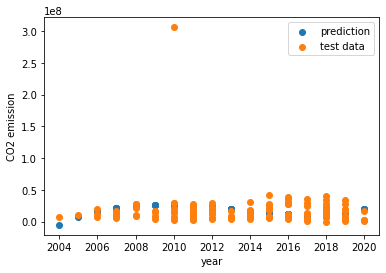

In [7]:
Y = air['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']
X = air.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]

X = np.array(X)
# X = X.reshape(-1,1) # alleen voor 1 input variable
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
degree = 5
polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train,Y_train)
predictions = polyreg.predict(X_test)

# print("Coefficients: \n", polyreg.coef_)
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))

plt.scatter(X_test[:, 0], predictions, label='prediction')
plt.scatter(X_test[:, 0], Y_test, label='test data')

plt.xlabel("year")
plt.ylabel("CO2 emission")
plt.legend()
plt.show()

In [8]:
copy2 = copy[copy['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].notna()] # drop all rows with NaN in target column
copy3 = df.copy()
dict_id2 = create_dict('organization_id', copy3)
dict_id2 = dict_clean_final(dict_id2, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
sector_dict = create_dict('GTAP sector', copy)
        # adding a column with scaled emissions


/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_19334/3953964208.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])


In [9]:
# copy2 = copy[copy['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].notna()] # drop all rows with NaN in target column
# copy3 = df.copy()
# dict_id2 = create_dict('organization_id', copy3)
# dict_id2 = dict_clean_final(dict_id2, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
# sector_dict = create_dict('GTAP sector', copy3)
# sector_dict = dict_clean_final(sector_dict, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')

# # for key in dict_id2:
# #     if len(dict_id2[key])==0:
# #         del dict_id2[key]


        
# dict_id2 = {k: v for k, v in dict_id2.items() if len(v) > 0}


# print(dict_id2[2760])

In [15]:

#dict_id2 = dict_clean_better(dict_id3, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1', ratio)

#Adds column to df which contains the scaled Emissions based on sector (Assuming sector input) 
def scale_emissions(df):
    df['CO2toRevenue'] = df['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']*(df['EmissionIndicators.TotalCO2EquivalentsEmissionsToRevenues']/df['EmissionDataPoints.CO2EquivalentsEmissionTotal'])
    return df

#Takes threshold in order to determine if you want to use sector or org_id
# returns true if you need to use sector

def sector_or_orgid(orgid, df, threshold = 10):
#     len(df[df['organization_id']==orgid])
    return len(df[df['organization_id']==orgid]) >= threshold

# func: makes predictions for a given org_id
# params: a dict of all org_id's as keys with their corresponding df's as values, and a specific org_id
# returns: the predictions and a plot of the predictions 
def predict(dictionary, orgid): 
    # decide wether to use sector or org_id for predictions:
    if sector_or_orgid(orgid, dictionary[orgid]):      
        print('predictions based on orgid')
        df = dictionary[orgid]
        df = df_clean(df, 'StatementDetails.FinancialPeriodFiscalYear')
        df = df_clean(df, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
        X = df.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]
        X = np.array(X)
        Y = df['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']
        title = 'Plot of emissions for company: ' + str(orgid)
        y_label = "CO2 emission"
    else: 
        print('predictions based on sector (using scaled data)')
        sector = copy['GTAP sector'].loc[orgid]
        
        df_sector = scale_emissions(sector_dict[sector])
        df_sector = df_clean(df_sector, 'CO2toRevenue')
        X = df_sector.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]
        if orgid == 2759: 
            print(sector)
            print(X)
        # use scaled emissions as target instead of scope1
        Y = df_sector['CO2toRevenue']
        title = 'Emissions for all companies in the sector: ' + sector
        y_label = 'CO2 emission per revenue'
        
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
    degree = 4
    polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(X_train,Y_train)
    predictions = polyreg.predict(X_test)
    mean_abs_error = mean_absolute_error(Y_test, predictions)
    print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))
#     plt.plot(X_test, predictions, label='prediction')
#     plt.scatter(X_test, Y_test, label='test data')
#     #X_test[:, 0]
#     plt.xlabel("year")
#     plt.ylabel(y_label)
#     plt.title(title)
#     plt.legend()
#     plt.show()
    return predictions, mean_abs_error



    
#dict_test = create_dict('organization_id', copy2)
# print(predict(dict_id2, 2964))

In [ ]:
abs_error_list = []
for key in dict_id2:
    print(key)
    if key in list(sector_dict['Sugar'].index):
        continue
    if len(dict_id2[key]) == 0:
        continue
    else: 
        abs_error_list.append(predict(dict_id2, key)[1])
    
print(abs_error_list)

1
2
3
4
5
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
6
predictions based on sector (using scaled data)
Mean absolute error: 142.93
Coefficient of determination: 0.00
7
8
9
10
11
predictions based on sector (using scaled data)
Mean absolute error: 3.24
Coefficient of determination: 0.19
12
13
14
15
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
16
17
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
18
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
19
20
predictions based on sector (using scaled data)
Mean absolute error: 283.16
Coefficient of determination: -0.04
21
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
22
23
24
25
26
27
28
29
predictions based on sector (usin

Mean absolute error: 23.65
Coefficient of determination: -0.00
192
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
193
predictions based on orgid
Mean absolute error: 3341277.09
Coefficient of determination: 0.63
194
195
196
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
197
198
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
199
200
predictions based on orgid
Mean absolute error: 12346.77
Coefficient of determination: 0.84
201
202
203
204
205
206
207
208
209
210
211
212
213
214
predictions based on orgid
Mean absolute error: 41726.89
Coefficient of determination: -3.33
215
216
217
218
219
220
221
predictions based on orgid
Mean absolute error: 2249.09
Coefficient of determination: 0.19
222
predictions based on sector (using scaled data)
Mean absolute error: 95.10
Coefficient of determination: -0.01
2

Mean absolute error: 142.93
Coefficient of determination: 0.00
426
427
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
428
429
430
431
432
433
434
435
436
437
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
438
439
440
441
442
443
444
445
446
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
447
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
448
449
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
450
predictions based on orgid
Mean absolute error: 9508.48
Coefficient of determination: -7.79
451
452
predictions based on orgid
Mean absolute error: 801810.85
Coefficient of determination: -3.52
453
454
predictions based on sector (using scaled data)
Mean absolute error: 3.24
Coeff

Mean absolute error: 40.45
Coefficient of determination: -0.01
612
613
predictions based on orgid
Mean absolute error: 158189.62
Coefficient of determination: -5.65
614
predictions based on orgid
Mean absolute error: 3483552.59
Coefficient of determination: -5.21
615
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
616
predictions based on orgid
Mean absolute error: 176709.14
Coefficient of determination: -11.08
617
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
618
predictions based on orgid
Mean absolute error: 991089.03
Coefficient of determination: 0.47
619
predictions based on orgid
Mean absolute error: 10326545.28
Coefficient of determination: 0.18
620
621
predictions based on orgid
Mean absolute error: 1578003.53
Coefficient of determination: 0.30
622
predictions based on sector (using scaled data)
Mean absolute error: 2505.83
Coefficient of determination

Mean absolute error: 535.88
Coefficient of determination: -0.00
743
744
predictions based on sector (using scaled data)
Mean absolute error: 267.48
Coefficient of determination: 0.05
745
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
746
predictions based on orgid
Mean absolute error: 1380781.52
Coefficient of determination: -2.24
747
predictions based on orgid
Mean absolute error: 8229.72
Coefficient of determination: -0.76
748
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
749
750
predictions based on orgid
Mean absolute error: 278010.12
Coefficient of determination: 0.86
751
752
753
754
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
755
756
757
758
759
760
761
762
763
predictions based on orgid
Mean absolute error: 1326789.48
Coefficient of determination: 0.72
764
predictions based on sector (usi

Mean absolute error: 335.37
Coefficient of determination: 0.00
959
960
961
962
predictions based on sector (using scaled data)
Mean absolute error: 3.24
Coefficient of determination: 0.19
963
964
965
966
967
968
969
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
970
971
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
972
973
974
975
976
977
predictions based on sector (using scaled data)
Mean absolute error: 283.16
Coefficient of determination: -0.04
978
979
980
981
982
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
983
984
985
986
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
987
988
989
990
991
predictions based on sector (using scaled data)
Mean absolute error: 2505.83
Coefficient of determination: -0.02
992
predictions based on o

Mean absolute error: 535.88
Coefficient of determination: -0.00
1177
1178
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
1179
1180
1181
1182
1183
1184
1185
1186
1187
predictions based on sector (using scaled data)
Mean absolute error: 593.59
Coefficient of determination: 0.05
1188
predictions based on sector (using scaled data)
Mean absolute error: 11.82
Coefficient of determination: 0.01
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
predictions based on sector (using scaled data)
Mean absolute error: 267.48
Coefficient of determination: 0.05
1199
1200
1201
1202
1203
1204
1205
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
1206
1207
predictions based on sector (using scaled data)
Mean absolute error: 961.61
Coefficient of determination: 0.02
1208
1209
1210
1211
1212
1213
1214
1215
predictions based on sector (using scaled data)
Mean absolute error: 593.59
C

Mean absolute error: 535.88
Coefficient of determination: -0.00
1509
1510
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
1511
1512
1513
1514
1515
1516
1517
1518
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
1534
1535
predictions based on sector (using scaled data)
Mean absolute error: 593.59
Coefficient of determination: 0.05
1536
1537
1538
predictions based on sector (using scaled data)
Mean absolute error: 2334.93
Coefficient of determination: -0.01
1539
1540
1541
1542
1543
1544
1545
1546
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
156

Mean absolute error: 17.68
Coefficient of determination: 0.00
1683
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1684
predictions based on orgid
Mean absolute error: 41188.05
Coefficient of determination: 0.02
1685
predictions based on orgid
Mean absolute error: 77129.48
Coefficient of determination: -1.34
1686
1687
predictions based on orgid
Mean absolute error: 1435.54
Coefficient of determination: -5.35
1688
1689
predictions based on orgid
Mean absolute error: 29457.48
Coefficient of determination: -1.95
1690
predictions based on orgid
Mean absolute error: 15667.66
Coefficient of determination: -20.02
1691
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
1692
predictions based on orgid
Mean absolute error: 137.17
Coefficient of determination: 0.45
1693
predictions based on orgid
Mean absolute error: 11621.63
Coefficient of determination: -0.11
1694
prediction

Mean absolute error: 17.68
Coefficient of determination: 0.00
1791
predictions based on orgid
Mean absolute error: 623.41
Coefficient of determination: 0.97
1792
1793
predictions based on orgid
Mean absolute error: 563.27
Coefficient of determination: 0.70
1794
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
1795
1796
1797
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1798
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
1799
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1800
predictions based on orgid
Mean absolute error: 4037.37
Coefficient of determination: -1.47
1801
1802
1803
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
1804
1805
predictions based on orgid
Mean abso

Mean absolute error: 335.37
Coefficient of determination: 0.00
1897
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
1898
1899
1900
1901
predictions based on sector (using scaled data)
Mean absolute error: 301.90
Coefficient of determination: -0.03
1902
predictions based on orgid
Mean absolute error: 18037.23
Coefficient of determination: -0.28
1903
1904
1905
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
1906
1907
1908
predictions based on sector (using scaled data)
Mean absolute error: 5935.71
Coefficient of determination: -0.03
1909
predictions based on sector (using scaled data)
Mean absolute error: 116.82
Coefficient of determination: -3.05
1910
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
1911
predictions based on orgid
Mean absolute error: 78879.47
Coefficient of determination: -2.11
1912
p

Mean absolute error: 40.45
Coefficient of determination: -0.01
2028
2029
2030
predictions based on sector (using scaled data)
Mean absolute error: 301.90
Coefficient of determination: -0.03
2031
2032
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2033
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
2034
2035
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
2036
2037
2038
2039
2040
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
2041
predictions based on sector (using scaled data)
Mean absolute error: 69.61
Coefficient of determination: 0.01
2042
2043
predictions based on sector (using scaled data)
Mean absolute error: 2505.83
Coefficient of determination: -0.02
2044
predictions based on sector (using scaled data)
Mean absolute error: 26

Mean absolute error: 267.48
Coefficient of determination: 0.05
2184
2185
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
2186
2187
2188
2189
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
2190
predictions based on sector (using scaled data)
Mean absolute error: 62.93
Coefficient of determination: -0.01
2191
2192
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
2193
2194
predictions based on orgid
Mean absolute error: 26297.87
Coefficient of determination: -6.59
2195
predictions based on sector (using scaled data)
Mean absolute error: 258.93
Coefficient of determination: 0.00
2196
2197
predictions based on orgid
Mean absolute error: 4259.40
Coefficient of determination: 0.40
2198
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
2199
predictions

Mean absolute error: 17.68
Coefficient of determination: 0.00
2343
predictions based on sector (using scaled data)
Mean absolute error: 1216.17
Coefficient of determination: -5.46
2344
predictions based on sector (using scaled data)
Mean absolute error: 2505.83
Coefficient of determination: -0.02
2345
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2346
2347
2348
predictions based on orgid
Mean absolute error: 28768.45
Coefficient of determination: -13.96
2349
predictions based on orgid
Mean absolute error: 3556374.24
Coefficient of determination: 0.78
2350
2351
2352
2353
2354
2355
2356
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
2357
2358
2359
2360
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
2361
predictions based on sector (using scaled data)
Mean absolute error: 2334.93
Coefficient of deter

Mean absolute error: 535.88
Coefficient of determination: -0.00
2492
predictions based on orgid
Mean absolute error: 3768796.40
Coefficient of determination: 0.64
2493
2494
predictions based on orgid
Mean absolute error: 16650.47
Coefficient of determination: -0.49
2495
predictions based on orgid
Mean absolute error: 16529712.07
Coefficient of determination: 0.22
2496
2497
predictions based on orgid
Mean absolute error: 208616.11
Coefficient of determination: -8.95
2498
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
2499
predictions based on orgid
Mean absolute error: 3050.69
Coefficient of determination: 0.42
2500
predictions based on sector (using scaled data)
Mean absolute error: 260.88
Coefficient of determination: 0.02
2501
2502
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2503
predictions based on sector (using scaled data)
Mean absolute error: 132.28


Mean absolute error: 535.88
Coefficient of determination: -0.00
2624
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
2625
2626
2627
predictions based on orgid
Mean absolute error: 37408.54
Coefficient of determination: -0.02
2628
predictions based on sector (using scaled data)
Mean absolute error: 69.61
Coefficient of determination: 0.01
2629
predictions based on orgid
Mean absolute error: 975322.94
Coefficient of determination: 0.48
2630
predictions based on orgid
Mean absolute error: 60237.73
Coefficient of determination: -1.48
2631
predictions based on orgid
Mean absolute error: 10605.90
Coefficient of determination: 0.97
2632
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
2633
predictions based on sector (using scaled data)
Mean absolute error: 11.82
Coefficient of determination: 0.01
2634
predictions based on orgid
Mean absolute error: 1359377.65
Coefficient

Mean absolute error: 335.37
Coefficient of determination: 0.00
2739
predictions based on sector (using scaled data)
Mean absolute error: 2505.83
Coefficient of determination: -0.02
2740
predictions based on orgid
Mean absolute error: 3865.31
Coefficient of determination: -0.04
2741
predictions based on sector (using scaled data)
Mean absolute error: 11.82
Coefficient of determination: 0.01
2742
2743
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
2744
2745
predictions based on sector (using scaled data)
Mean absolute error: 246.45
Coefficient of determination: -0.08
2746
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2747
predictions based on sector (using scaled data)
Mean absolute error: 258.93
Coefficient of determination: 0.00
2748
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
2749
predictions 

Mean absolute error: 535.88
Coefficient of determination: -0.00
2877
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
2878
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
2879
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2880
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2881
2882
2883
predictions based on orgid
Mean absolute error: 810576.37
Coefficient of determination: -2339.95
2884
predictions based on orgid
Mean absolute error: 437501.51
Coefficient of determination: 0.95
2885
predictions based on orgid
Mean absolute error: 9135.04
Coefficient of determination: -1.89
2886
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
2887
predictions based on sector (using scaled d

Mean absolute error: 535.88
Coefficient of determination: -0.00
3004
3005
predictions based on orgid
Mean absolute error: 30035.21
Coefficient of determination: -2.89
3006
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3007
predictions based on orgid
Mean absolute error: 177.88
Coefficient of determination: 0.90
3008
3009
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3010
predictions based on sector (using scaled data)
Mean absolute error: 301.90
Coefficient of determination: -0.03
3011
predictions based on orgid
Mean absolute error: 12425655.44
Coefficient of determination: -7.98
3012
3013
predictions based on orgid
Mean absolute error: 2639.44
Coefficient of determination: 0.45
3014
3015
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3016
predictions based on sector (using scaled data)
Mean 

Mean absolute error: 132.28
Coefficient of determination: -0.17
3137
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
3138
3139
3140
3141
3142
3143
3144
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
3145
3146
predictions based on sector (using scaled data)
Mean absolute error: 11.82
Coefficient of determination: 0.01
3147
predictions based on sector (using scaled data)
Mean absolute error: 2505.83
Coefficient of determination: -0.02
3148
3149
predictions based on sector (using scaled data)
Mean absolute error: 142.93
Coefficient of determination: 0.00
3150
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
3151
3152
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3153
predictions based on sector (using scaled data)
Mean absolute error: 23.65
C

Mean absolute error: 111.20
Coefficient of determination: -0.00
3263
predictions based on orgid
Mean absolute error: 1202.28
Coefficient of determination: -0.06
3264
predictions based on orgid
Mean absolute error: 233431.50
Coefficient of determination: -27.57
3265
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3266
3267
3268
predictions based on sector (using scaled data)
Mean absolute error: 750.39
Coefficient of determination: -0.05
3269
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3270
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
3271
predictions based on orgid
Mean absolute error: 1862.50
Coefficient of determination: -0.44
3272
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3273
predictions based on sector (using scaled da

Mean absolute error: 111.20
Coefficient of determination: -0.00
3389
predictions based on orgid
Mean absolute error: 13241.48
Coefficient of determination: -10.65
3390
predictions based on orgid
Mean absolute error: 7535125.02
Coefficient of determination: -10.22
3391
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
3392
3393
3394
predictions based on orgid
Mean absolute error: 2818.56
Coefficient of determination: -28.44
3395
predictions based on sector (using scaled data)
Mean absolute error: 246.45
Coefficient of determination: -0.08
3396
3397
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
3398
predictions based on sector (using scaled data)
Mean absolute error: 260.88
Coefficient of determination: 0.02
3399
predictions based on sector (using scaled data)
Mean absolute error: 62.93
Coefficient of determination: -0.01
3400
3401
predictions based on sector (using

Mean absolute error: 132.28
Coefficient of determination: -0.17
3541
3542
3543
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3544
3545
3546
predictions based on orgid
Mean absolute error: 14984.40
Coefficient of determination: 0.74
3547
3548
predictions based on sector (using scaled data)
Mean absolute error: 142.93
Coefficient of determination: 0.00
3549
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3550
3551
3552
3553
3554
3555
predictions based on orgid
Mean absolute error: 27138.32
Coefficient of determination: -0.23
3556
predictions based on orgid
Mean absolute error: 677311.41
Coefficient of determination: -9.80
3557
predictions based on orgid
Mean absolute error: 726560.00
Coefficient of determination: 0.51
3558
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
3559
3560
3561
3562
predictio

Mean absolute error: 535.88
Coefficient of determination: -0.00
3655
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3656
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3657
3658
3659
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
3660
3661
predictions based on orgid
Mean absolute error: 21283.52
Coefficient of determination: -5.02
3662
3663
3664
3665
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
3666
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
3667
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
3668
predictions based on orgid
Mean absolute error: 312163.04
Coefficient of determination: -6.04
3669
3670
pre

Mean absolute error: 8271.31
Coefficient of determination: -2.27
3765
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
3766
predictions based on sector (using scaled data)
Mean absolute error: 283.16
Coefficient of determination: -0.04
3767
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
3768
predictions based on orgid
Mean absolute error: 2506178.78
Coefficient of determination: 0.86
3769
predictions based on sector (using scaled data)
Mean absolute error: 593.59
Coefficient of determination: 0.05
3770
predictions based on orgid
Mean absolute error: 284295.02
Coefficient of determination: -0.01
3771
predictions based on sector (using scaled data)
Mean absolute error: 95.10
Coefficient of determination: -0.01
3772
predictions based on orgid
Mean absolute error: 202.12
Coefficient of determination: 0.65
3773
predictions based on orgid
Mean absolute error: 341.00
Co

Mean absolute error: 40.45
Coefficient of determination: -0.01
3881
3882
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
3883
predictions based on sector (using scaled data)
Mean absolute error: 260.88
Coefficient of determination: 0.02
3884
3885
predictions based on orgid
Mean absolute error: 4301.15
Coefficient of determination: -3.50
3886
predictions based on orgid
Mean absolute error: 368.97
Coefficient of determination: -2.76
3887
3888
3889
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
3890
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
3891
3892
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
3893
3894
3895
predictions based on orgid
Mean absolute error: 129602.73
Coefficient of determination: 0.81
3896
3897
predictions based 

Mean absolute error: 17.68
Coefficient of determination: 0.00
4018
predictions based on orgid
Mean absolute error: 2943.90
Coefficient of determination: 0.38
4019
predictions based on orgid
Mean absolute error: 1805.17
Coefficient of determination: 0.65
4020
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
4021
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
4022
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
4023
4024
predictions based on sector (using scaled data)
Mean absolute error: 142.93
Coefficient of determination: 0.00
4025
4026
predictions based on sector (using scaled data)
Mean absolute error: 19.60
Coefficient of determination: -0.03
4027
predictions based on sector (using scaled data)
Mean absolute error: 593.59
Coefficient of determination: 0.05
4028
4029
4030
predictions based on o

Mean absolute error: 535.88
Coefficient of determination: -0.00
4118
predictions based on orgid
Mean absolute error: 49130.93
Coefficient of determination: -1.75
4119
4120
4121
4122
4123
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
4124
predictions based on orgid
Mean absolute error: 16941.91
Coefficient of determination: -12.03
4125
4126
predictions based on sector (using scaled data)
Mean absolute error: 5935.71
Coefficient of determination: -0.03
4127
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
4128
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
4129
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
4130
4131
4132
4133
4134
predictions based on sector (using scaled data)
Mean absolute error: 26.25
Coefficient of determination: -2.9

Mean absolute error: 17.68
Coefficient of determination: 0.00
4244
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
4245
predictions based on sector (using scaled data)
Mean absolute error: 2505.83
Coefficient of determination: -0.02
4246
predictions based on sector (using scaled data)
Mean absolute error: 258.93
Coefficient of determination: 0.00
4247
predictions based on sector (using scaled data)
Mean absolute error: 62.93
Coefficient of determination: -0.01
4248
predictions based on sector (using scaled data)
Mean absolute error: 246.45
Coefficient of determination: -0.08
4249
predictions based on sector (using scaled data)
Mean absolute error: 142.93
Coefficient of determination: 0.00
4250
4251
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
4252
4253
4254
4255
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determin

Mean absolute error: 62.93
Coefficient of determination: -0.01
4373
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
4374
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
4375
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
4376
predictions based on orgid
Mean absolute error: 18141.70
Coefficient of determination: -0.03
4377
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
4378
predictions based on orgid
Mean absolute error: 225837.09
Coefficient of determination: -18.88
4379
predictions based on orgid
Mean absolute error: 827519.67
Coefficient of determination: 0.64
4380
predictions based on orgid
Mean absolute error: 1237.48
Coefficient of determination: 0.88
4381
predictions based on orgid
Mean absolute error: 26924.51
Coefficient of dete

Mean absolute error: 335.37
Coefficient of determination: 0.00
4473
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
4474
4475
4476
4477
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
4478
4479
4480
4481
predictions based on orgid
Mean absolute error: 9919.12
Coefficient of determination: 0.16
4482
predictions based on orgid
Mean absolute error: 5221.17
Coefficient of determination: -0.79
4483
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
4484
predictions based on orgid
Mean absolute error: 368.18
Coefficient of determination: 0.92
4485
predictions based on sector (using scaled data)
Mean absolute error: 31.51
Coefficient of determination: -0.66
4486
predictions based on sector (using scaled data)
Mean absolute error: 31.56
Coefficient of determination: -0.16
4487
4488
predictions based on sector

Mean absolute error: 535.88
Coefficient of determination: -0.00
4588
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
4589
4590
predictions based on orgid
Mean absolute error: 699.74
Coefficient of determination: -1.47
4591
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
4592
predictions based on orgid
Mean absolute error: 725.80
Coefficient of determination: -1.71
4593
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
4594
predictions based on orgid
Mean absolute error: 35582.69
Coefficient of determination: -6.93
4595
4596
4597
predictions based on orgid
Mean absolute error: 402254.36
Coefficient of determination: 0.13
4598
predictions based on orgid
Mean absolute error: 102637.09
Coefficient of determination: -1.37
4599
predictions based on sector (using scaled data)
Mean absolute error: 148.80
Coe

Mean absolute error: 335.37
Coefficient of determination: 0.00
4707
predictions based on sector (using scaled data)
Mean absolute error: 2334.93
Coefficient of determination: -0.01
4708
predictions based on sector (using scaled data)
Mean absolute error: 19.60
Coefficient of determination: -0.03
4709
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
4710
4711
4712
predictions based on orgid
Mean absolute error: 2213.85
Coefficient of determination: 0.80
4713
predictions based on sector (using scaled data)
Mean absolute error: 3.24
Coefficient of determination: 0.19
4714
predictions based on sector (using scaled data)
Mean absolute error: 62.93
Coefficient of determination: -0.01
4715
predictions based on sector (using scaled data)
Mean absolute error: 106.23
Coefficient of determination: -0.54
4716
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
4717
4718
4719
pr

Mean absolute error: 40.45
Coefficient of determination: -0.01
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
predictions based on sector (using scaled data)
Mean absolute error: 258.93
Coefficient of determination: 0.00
5460
5461
5462
predictions based on sector (using scaled data)
Mean absolute error: 62.93
Coefficient of determination: -0.01
5463
5464
5465
5466
5467
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
5468
5469
5470
5471
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519


Mean absolute error: 535.88
Coefficient of determination: -0.00
5832
predictions based on sector (using scaled data)
Mean absolute error: 62.93
Coefficient of determination: -0.01
5833
5834
predictions based on orgid
Mean absolute error: 928.70
Coefficient of determination: 0.52
5835
predictions based on orgid
Mean absolute error: 84053.28
Coefficient of determination: 0.75
5836
5837
predictions based on sector (using scaled data)
Mean absolute error: 77.63
Coefficient of determination: -0.13
5838
5839
5840
5841
5842
5843
5844
5845
predictions based on sector (using scaled data)
Mean absolute error: 135.55
Coefficient of determination: 0.05
5846
5847
5848
predictions based on orgid
Mean absolute error: 4195713.42
Coefficient of determination: 0.66
5849
5850
predictions based on orgid
Mean absolute error: 782988.51
Coefficient of determination: 0.87
5851
predictions based on sector (using scaled data)
Mean absolute error: 258.93
Coefficient of determination: 0.00
5852
5853
predictions b

Mean absolute error: 423496.32
Coefficient of determination: -44.09
6045
6046
predictions based on sector (using scaled data)
Mean absolute error: 246.45
Coefficient of determination: -0.08
6047
6048
predictions based on orgid
Mean absolute error: 206103.07
Coefficient of determination: 0.27
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
predictions based on sector (using scaled data)
Mean absolute error: 260.88
Coefficient of determination: 0.02
6065
6066
6067
6068
predictions based on orgid
Mean absolute error: 4128.19
Coefficient of determination: -0.06
6069
6070
6071
6072
6073
predictions based on orgid
Mean absolute error: 2166002.11
Coefficient of determination: -3.56
6074
predictions based on orgid
Mean absolute error: 1086.50
Coefficient of determination: -0.38
6075
6076
6077
6078
6079
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
6080
6081
6082
6083
6084
6085
6086
predictions bas

Mean absolute error: 111.20
Coefficient of determination: -0.00
6288
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
6289
predictions based on orgid
Mean absolute error: 143773.46
Coefficient of determination: -13.14
6290
6291
6292
predictions based on orgid
Mean absolute error: 1862.75
Coefficient of determination: -0.18
6293
6294
6295
predictions based on sector (using scaled data)
Mean absolute error: 114.49
Coefficient of determination: 0.01
6296
predictions based on orgid
Mean absolute error: 40821.27
Coefficient of determination: -1.02
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
predictions based on orgid
Mean absolute error: 96591.03
Coefficient of determination: 0.66
6335
predictions based on orgid
Mean absolute error: 29670.47
Coefficient of determination: -111.32
6336
633

Mean absolute error: 535.88
Coefficient of determination: -0.00
6535
predictions based on sector (using scaled data)
Mean absolute error: 148.80
Coefficient of determination: -0.12
6536
6537
6538
6539
predictions based on orgid
Mean absolute error: 664114.29
Coefficient of determination: 0.90
6540
6541
6542
predictions based on orgid
Mean absolute error: 7194.47
Coefficient of determination: -14.61
6543
6544
6545
6546
6547
6548
6549
predictions based on sector (using scaled data)
Mean absolute error: 114.49
Coefficient of determination: 0.01
6550
6551
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
6552
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
6553
6554
6555
6556
6557
predictions based on orgid
Mean absolute error: 2620928.21
Coefficient of determination: 0.57
6558
6559
6560
6561
predictions based on orgid
Mean absolute error: 16168.70
Coefficient of det

Mean absolute error: 535.88
Coefficient of determination: -0.00
6828
6829
6830
6831
6832
6833
6834
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
6835
6836
6837
6838
predictions based on orgid
Mean absolute error: 9058.25
Coefficient of determination: 0.65
6839
predictions based on orgid
Mean absolute error: 36210.61
Coefficient of determination: -1.19
6840
6841
predictions based on sector (using scaled data)
Mean absolute error: 719.29
Coefficient of determination: 0.01
6842
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
6843
6844
predictions based on orgid
Mean absolute error: 4707078.53
Coefficient of determination: -0.98
6845
6846
6847
6848
predictions based on sector (using scaled data)
Mean absolute error: 8.32
Coefficient of determination: -0.23
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
687

Mean absolute error: 535.88
Coefficient of determination: -0.00
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
predictions based on sector (using scaled data)
Mean absolute error: 750.39
Coefficient of determination: -0.05
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
predictions based on orgid
Mean absolute error: 6819.01
Coefficient of determination: 0.95
7442
7443
predictions based on orgid
Mean absolute error: 181811.79
Coefficient of determination: -1.14
7444
7445
7446
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
7447
7448
7449
predictions based on orgid
Mean absolute error: 11543.80
Coefficient of determination: -2.61
7450
7451
7452
7453
7454
7455
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
7456
7457
7458
7459
7460
7461
7462
7463
74

Mean absolute error: 535.88
Coefficient of determination: -0.00
7961
7962
predictions based on orgid
Mean absolute error: 53741.30
Coefficient of determination: -2.73
7963
7964
7965
7966
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
7967
7968
predictions based on orgid
Mean absolute error: 4542.20
Coefficient of determination: 0.29
7969
7970
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
7986
7987
7988
7989
7990
predictions based on sector (using scaled data)
Mean absolute error: 72.11
Coefficient of determination: 0.23
7991
7992
7993
predictions based on sector (using scaled data)
Mean absolute error: 132.28
Coefficient of determination: -0.17
7994
7995
7996
7997
7998
7999
8

Mean absolute error: 535.88
Coefficient of determination: -0.00
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
predictions based on sector (using scal

Mean absolute error: 535.88
Coefficient of determination: -0.00
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
9495
9496
predictions based on orgid
Mean absolute error: 6615.72
Coefficient of determination: 0.16
9497
9498
9499
predictions based on sector (using scaled data)
Mean absolute error: 19.60
Coefficient of determination: -0.03
9500
9501
9502
9503
9504
predictions based on sector (using scaled data)
Mean absolute error: 69.61
Coefficient of determination: 0.01
9505
9506
9507
9508
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
predictions based on sector (using scaled data)
Mean absolute error: 3.94
Coefficient of determination: -0.07
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9

Mean absolute error: 40.45
Coefficient of determination: -0.01
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
predictions based on sector (using scaled data)
Mean absolute error: 2505.83
Coefficient of determination: -0.02
10103
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
10104
10105
10106
predictions based on sector (using scaled data)
Mean absolute error: 335.37
Coefficient of determination: 0.00
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
10117
10118
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
10119
10120
10121
10122
10123
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.00
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136


Mean absolute error: 23.65
Coefficient of determination: -0.00
10671
10672
10673
10674
10675
predictions based on orgid
Mean absolute error: 693.80
Coefficient of determination: -14.56
10676
10677
10678
10679
10680
10681
10682
10683
10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
predictions based on sector (using scaled data)
Mean absolute error: 1216.17
Coefficient of determination: -5.46
10711
10712
10713
10714
10715
10716
10717
predictions based on sector (using scaled data)
Mean absolute error: 148.80
Coefficient of determination: -0.12
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
predictions based on sector (using scaled data)
Mean absolute error: 535.88
Coefficient of determination: -0.0

In [ ]:
print(mean(abs_error_list))
print(max(abs_error_list))
print(min(abs_error_list))
print(median(abs_error_list))

In [ ]:
print(len(abs_error_list))

In [ ]:
# print(dict_id2[2759])
print(list(sector_dict['Sugar'].index))
print(len(dict_id2[14897]))